# Figure 3: Effect of vibrations: one model example

In [ ]:
import matplotlib.cm as cm
from directory_paths import SAVE_DIR
from train.train_model_utils import *
import pandas as pd
import matplotlib.pyplot as plt
from utils.muscle_names import MUSCLE_NAMES
from utils.analysis_plots_helper import *


created directory  /media/data16/adriana/ProprioPerception/0_Zenodo/plots


In [2]:
original_hex_biceps = "#FF3B30"
original_hex_tri = "#00C7BE"
trilat_gradient = generate_color_gradient(original_hex_tri)  # Gradient for TRIlat
bcilong_gradient = generate_color_gradient(original_hex_biceps)  # Gradient for BIClong

MARKER_LIST = ["o", "X", "^", "p", "d", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"]

aff_Ia_color = "#762A83"
aff_II_color = "#DE8F05"
colors_aff_dict = {"i_a": aff_Ia_color, "ii": aff_II_color}

set_publication_style()

In [3]:
# for some plots
ELBOW_ANGLE_INDEX = 6
TIME = 1152
sample_rate = 240

## Load data from trained model

In [4]:
### Load directly from downloaded figure data if available 
num_vib_muscles = 7
num_cols = 12
test_exp_dir = "vib_multiple_freqs"
df_file_path = os.path.join(
    SAVE_DIR,
    "data_for_figs", 
    f"df_fig3_{test_exp_dir}_{num_vib_muscles}Muscles_numCols-{num_cols}.h5")

### Or load from vibration experiments directly
task = "letter_reconstruction_joints"
coef_seeds_to_load = None # to use all available

## For pre-trained models downloaded
train_seeds_to_load = ['9']
model_path = os.path.join(
    SAVE_DIR,
    f"trained_models/experiment_causal_flag-pcr_optimized_linearFR_5_5_{task}/",
)
INPUT_DATA = "ES3D"
test_exp_dir = "vib_multiple_freqs"
PATH_TO_SAVE = model_path + "/" + "test" + "/" + INPUT_DATA + "/" + test_exp_dir

vib_muscles = None # to load all available
vib_range = None

# Initialize an empty list to store DataFrames
columns_to_load = ["vib_freq", "vib_muscles", "trial", "elbow_angle", "vib_angle_diff_elbow"]
columns_to_load = columns_to_load + ["predicted_outputs","predicted_vib_outputs","inputs_vib"]
# columns_to_load = None

path_save = model_path + "/plots/" + test_exp_dir
if not os.path.exists(path_save):
    os.makedirs(path_save)
    print("created directory ", path_save)

created directory  /media/data16/adriana/ProprioPerception/0_Zenodo/trained_models/experiment_causal_flag-pcr_optimized_linearFR_5_5_letter_reconstruction_joints//plots/vib_multiple_freqs


In [5]:
# Use dataframe to load data or from the models if df not available
loaded_from_hdf = False

# if figure data is available, load it
if os.path.exists(df_file_path):
    print("loading df_all from ", df_file_path)
    df_all = pd.read_hdf(df_file_path, key="df", mode="r")
    loaded_from_hdf = True
else:
    df_all = load_vibration_data(
        model_path=model_path,
        test_exp_dir=test_exp_dir,
        vib_muscles=vib_muscles,
        vib_range=vib_range,
        columns_to_load=columns_to_load,
        coef_seeds_to_load=coef_seeds_to_load,
        train_seeds_to_load=train_seeds_to_load,
        input_data=INPUT_DATA,
        sample_rate=SAMPLE_RATE,
        exact_vib_muscles=True
    )

loading df_all from  /media/data16/adriana/ProprioPerception/0_Zenodo/data_for_figs/df_fig3_vib_multiple_freqs_7Muscles_numCols-12.h5


In [6]:
# remove rows with same coef_seed, train_seed, vib_musclse_str, vib_freq and trial
df_all_f = df_all.drop_duplicates(subset=["coef_seed", "train_seed", "vib_muscles_str", "vib_freq", "trial"], keep="first")

# to check that the data is loaded correctly
# summary = summarize_dataframe(df_all_f)
# summary

In [7]:
# save df if not loaded from hdf
if not loaded_from_hdf:
    num_cols = len(df_all.columns)
    num_vib_muscles = len(df_all["vib_muscles_str"].unique())
    df_file_path = model_path + f"df_fig3_{test_exp_dir}_{num_vib_muscles}Muscles_numCols-{num_cols}.h5"
    # save df_all to h5 file
    df_all.to_hdf(df_file_path, key="df", mode="w")
    print("saved df_all to ", df_file_path)

## Fig 3a

1. Select trial with predicted_outputs and elbow_angle near 90deg
2. Select vibration frequency = 70
3. For vib_muscles in [[BIClong, BICshort], [BCIlong], ["TRIlat", "TRIlong", "TRImed"]]:
    plot predicted_vib_outputs vs time with different colors 
    Plot 5 subplots with values of channel 0 vs time for muscles "TRIlat", "TRIlong", "TRImed" and BIClong, BICshort


In [8]:
# Step 1: Filter the DataFrame
def find_nearest_trial(df, target_angle=90, tolerance=5):
    """Find the trial with an elbow_angle near the target angle."""
    df = df.dropna(subset=["predicted_vib_outputs"])
    mask_angle = (df["elbow_angle"] >= target_angle - tolerance) & (df["elbow_angle"] <= target_angle + tolerance)
    # select the value of the first trial that matches
    filtered_df = df[mask_angle]
    trial = filtered_df.iloc[0]["trial"]
    # mask_vib_freq = df["vib_freq"] == vib_freq
    # filtered_df = df[mask_angle & mask_vib_freq]
    # return filtered_df
    return trial

import colorsys

def adjust_color(hex_color, hue_shift, saturation=1.0, value=0.78):
    # Convert hex to RGB (0-255 scale)
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    # Convert RGB to HSV (0-1 scale)
    h, s, v = colorsys.rgb_to_hsv(r/255, g/255, b/255)
    # Adjust hue, ensure it stays within [0, 1]
    h = (h + hue_shift/360) % 1
    # Convert back to RGB (0-1 scale)
    r, g, b = colorsys.hsv_to_rgb(h, saturation, value)
    # Convert RGB to hex
    return f'#{int(r*255):02X}{int(g*255):02X}{int(b*255):02X}'


In [9]:
elbow_angle_to_plot = 90
vib_freq_to_plot = 80
channel_idx = 0
# channel_idx = 9 # type ii
muscle_groups_to_plot = [["BIClong", "BICshort"], ["BIClong"], ["TRIlat", "TRIlong", "TRImed"], ["TRIlat"]]

In [11]:
# Define muscle groups
muscle_groups = [["BIClong", "BICshort"], ["BIClong"], ["BICshort"], ["TRIlat", "TRIlong", "TRImed"], ["TRIlat"]]
original_hex_tri = "00C7BE"
tri_colors = [
    adjust_color(original_hex_tri, 10),
    adjust_color(original_hex_tri, -10),
]
original_hex_biceps = "FF3B30"
biceps_colors = [
   adjust_color(original_hex_biceps, 10), 
   adjust_color(original_hex_biceps, -10),
   adjust_color(original_hex_biceps, 20),
]
muscle_colors =biceps_colors + tri_colors
# add column to target_trials with color from muscle_colors depending on muscle group vibrated 

# Create a mapping of muscle groups to colors
muscle_group_to_color = {tuple(group): color for group, color in zip(muscle_groups, muscle_colors)}

# Function to find the matching color for a given muscle group
def assign_color(vib_muscles):
    vib_muscles_set = set(vib_muscles)
    for group, color in muscle_group_to_color.items():
        if vib_muscles_set == set(group):  # Exact match of muscle group
            return color
    return "#000000"  # Default color (black) for unmatched cases

# Apply the function to add a new column
df_all["group_color"] = df_all["vib_muscles"].apply(assign_color)
df_noNan = df_all.dropna(subset=["inputs_vib"])

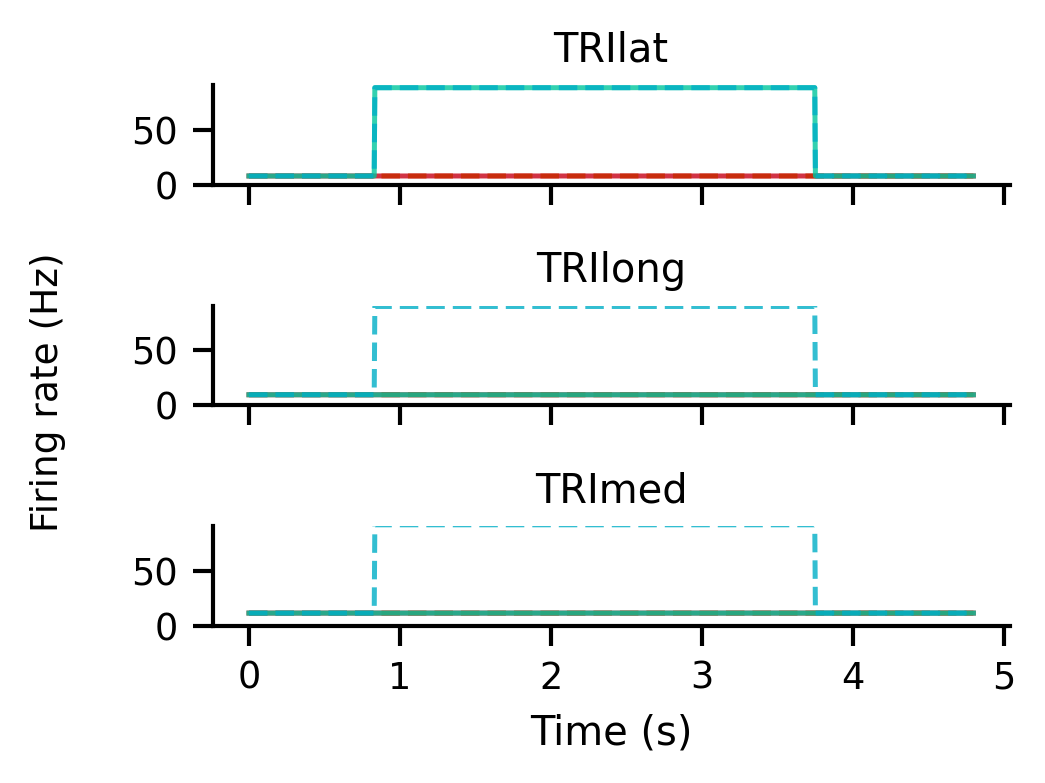

In [12]:
# Filter DataFrame
target_trial = find_nearest_trial(df_all, elbow_angle_to_plot, tolerance=10)
# filter df by target trial and vibration frequency
target_trials = df_all[(df_all["trial"] == target_trial) & (df_all["vib_freq"] == vib_freq_to_plot)]
target_trials = target_trials[target_trials["vib_muscles"].apply(lambda x: x in muscle_groups_to_plot)]
# sort by muscles_groups to plot 
target_trials = target_trials.sort_values("vib_muscles")

time_range = np.arange(TIME)  # Time axis
time_range = time_range / sample_rate  # Convert to seconds

# Step 3: Plot subplots for channel 0 values
# muscles_to_plot = ["TRIlat", "TRIlong", "TRImed", "BIClong", "BICshort"]
muscles_to_plot = ["TRIlat", "TRIlong", "TRImed"]
# find indices of muscles in `muscles_to_plot` in MUSCLE_NAMES  
muscles_idx_to_plot = [MUSCLE_NAMES.index(muscle) for muscle in muscles_to_plot]
fig, axes = plt.subplots(len(muscles_to_plot), 1, figsize=BASE_FIG_SIZE_1COL, sharex=True)

for idx, muscle in enumerate(muscles_to_plot):
    ax = axes[idx] 
    for row in target_trials.itertuples():
        # Extract and plot `inputs_vib` vs. time
        inputs_vib = np.array(row.inputs_vib)
        if len(row.vib_muscles) > 1:
            ls = '--'
        else:
            ls = '-'
        ax.plot(time_range, inputs_vib[channel_idx, muscles_idx_to_plot[idx],:], label=f'Muscles vibrated {row.vib_muscles}', alpha=0.8, color=row.group_color, ls=ls)
    # ax.set_title(f"Afferent {channel_idx} firing rate for {muscle}")
    ax.set_title(f"{muscle}")
    # ax.legend()
    # ax.set_ylabel(f"Firing rate (Hz)")
    ax.set_ylim(0,90)
# set y label for all subplots
fig.supylabel("Firing rate (Hz)", fontsize=9)

plt.xlabel("Time (s)")
plt.tight_layout()
plt.savefig(f"{path_save}/inputs_trial_{target_trial}_muscle_{len(muscles_to_plot)}_channel_{channel_idx}.svg")
plt.show()




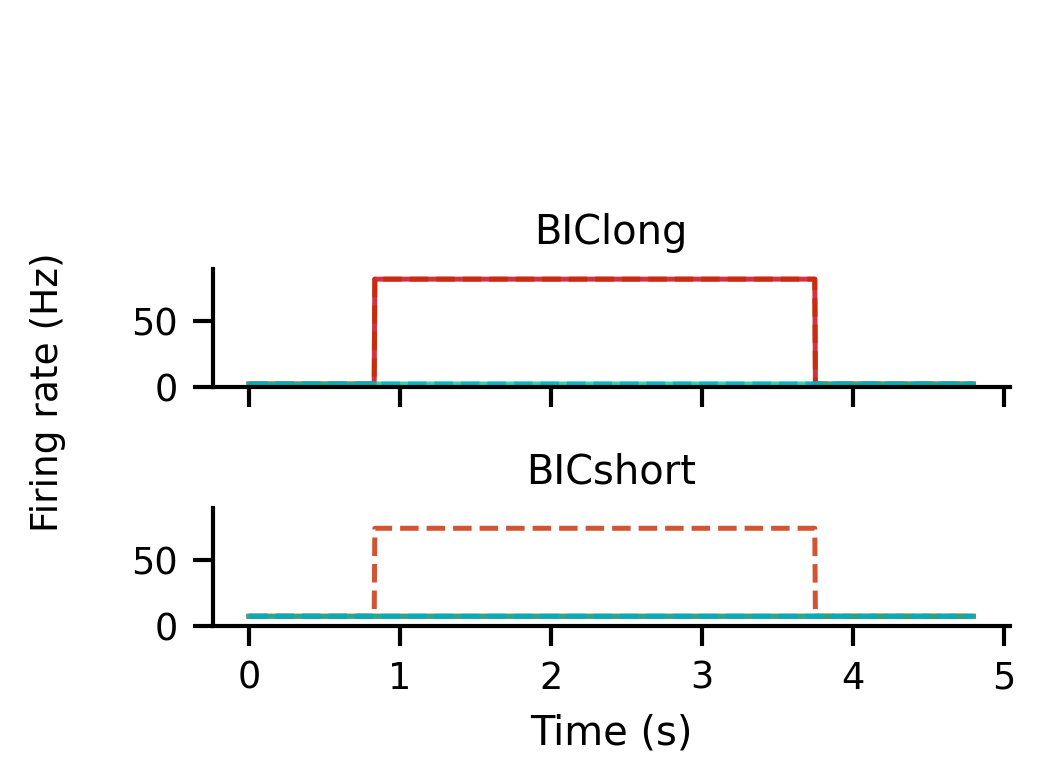

In [13]:

# Step 3: Plot subplots for channel 0 values
muscles_to_plot = ["BIClong", "BICshort"]
# find indices of muscles in `muscles_to_plot` in MUSCLE_NAMES  
muscles_idx_to_plot = [MUSCLE_NAMES.index(muscle) for muscle in muscles_to_plot]
# fig, axes = plt.subplots(len(muscles_to_plot), 1, figsize=(BASE_FIG_SIZE_1COL[0],BASE_FIG_SIZE_1COL[1]*2.2/3), sharex=True)
fig, axes = plt.subplots(len(muscles_to_plot)+1, 1, figsize=BASE_FIG_SIZE_1COL, sharex=True)
for idx, muscle in enumerate(muscles_to_plot):
    ax = axes[idx+1] 
    for row in target_trials.itertuples():
        # Extract and plot `inputs_vib` vs. time
        inputs_vib = np.array(row.inputs_vib)
        if len(row.vib_muscles) > 1:
            ls = '--'
        else:
            ls = '-'
        ax.plot(time_range, inputs_vib[channel_idx, muscles_idx_to_plot[idx],:], label=f'Muscles vibrated {row.vib_muscles}', alpha=0.8, color=row.group_color, ls=ls)
    # ax.set_title(f"Afferent {channel_idx} firing rate for {muscle}")
    ax.set_title(f"{muscle}")
    # ax.legend()
    # ax.set_ylabel(f"Firing rate (Hz)")
    ax.set_ylim(0,90)
# remove last axis
axes[0].axis('off')
fig.supylabel("Firing rate (Hz)", fontsize=9)

plt.xlabel("Time (s)")
plt.tight_layout()
plt.savefig(f"{path_save}/inputs_trial_{target_trial}_muscle-BIC_{len(muscles_to_plot)}_channel_{channel_idx}.svg")
plt.show()


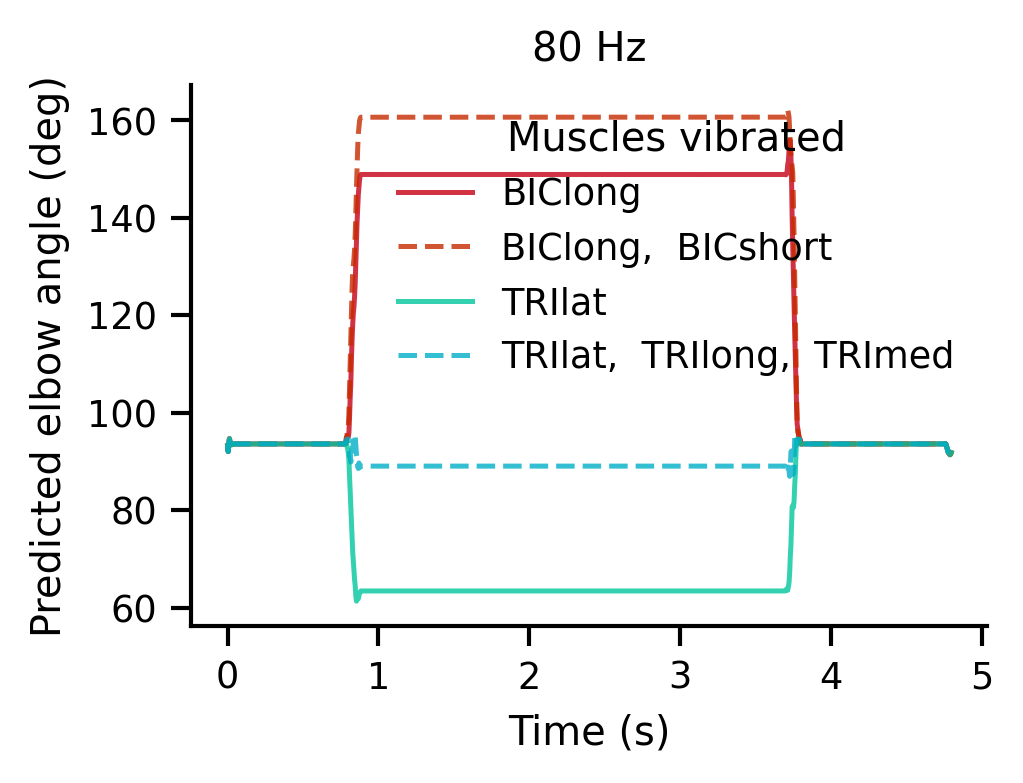

In [14]:

# for each row, plot the prdicted elbow angle vib
fig, ax = plt.subplots(1, 1, figsize=BASE_FIG_SIZE_1COL, sharex=True)

for row in target_trials.itertuples():
    # Extract and plot `predicted_vib_outputs` vs. time
    if len(row.vib_muscles) > 1:
        ls = '--'
    else:
        ls = '-'
    predicted_vib_outputs = np.array(row.predicted_vib_outputs)
    # label is the list with the muscles vibrated
    label = str(row.vib_muscles).replace("[", "").replace("]", "").replace(",", ", ").replace("'", "")
    ax.plot(time_range, predicted_vib_outputs[:, ELBOW_ANGLE_INDEX], label=label, alpha=0.8, color=row.group_color, ls=ls)
ax.set_title(f"{vib_freq_to_plot} Hz")
# ax.legend()
# Adjust legend: make it larger and simpler
legend = ax.legend(title="Muscles vibrated")

ax.set_ylabel(f"Predicted elbow angle (deg)")

plt.xlabel("Time (s)")
plt.tight_layout()
plt.savefig(f"{path_save}/predElbow_trial_{target_trial}_muscle_{len(muscle_groups_to_plot)}.svg")
plt.show()

## Fig 3 b

- select all trials vib_muscles Trilat and Bicepslong
- for each muscle Trilat and BIClong, plot FR at time 500 vs vibration frequency, different lines for each channel from 0 to 5 

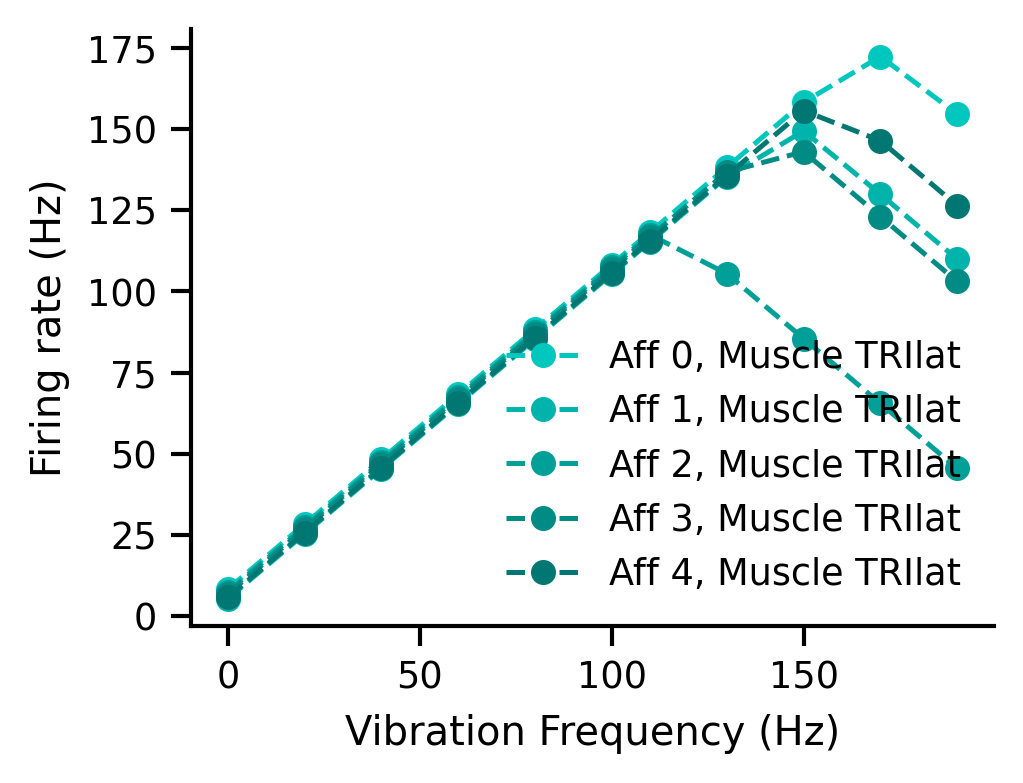

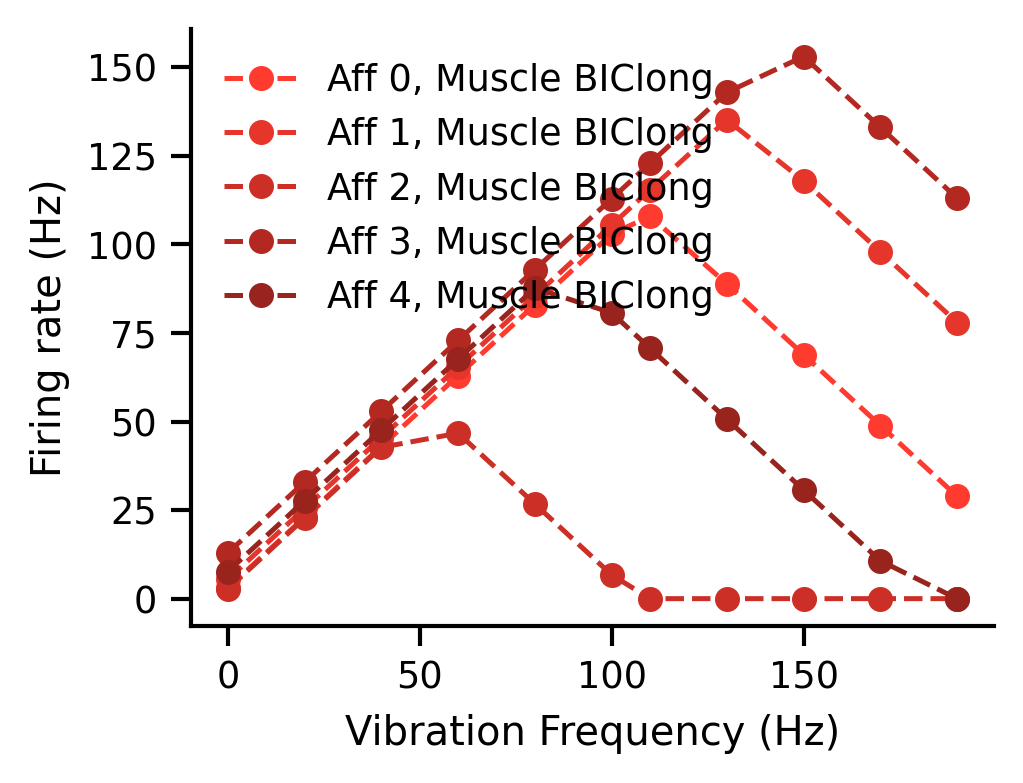

In [15]:
# Filter DataFrames for the specific muscles
tri_trials_noNan = df_noNan[df_noNan["vib_muscles"].apply(lambda x: x == ["TRIlat"])]
bic_trials_noNan = df_noNan[df_noNan["vib_muscles"].apply(lambda x: x == ["BIClong"])]
tri_trials = df_all[df_all["vib_muscles"].apply(lambda x: x == ["TRIlat"])]
bic_trials = df_all[df_all["vib_muscles"].apply(lambda x: x == ["BIClong"])]

channels = [0,1,2,3,4]

# Plot for TRIlat
plot_vibration_vs_input(tri_trials_noNan, ["TRIlat"], channels=channels, time_point=500, colors=trilat_gradient, save_path=path_save)

# Plot for BIClong
plot_vibration_vs_input(bic_trials_noNan, ["BIClong"], channels=channels, time_point=500, colors=bcilong_gradient, save_path=path_save)



In [16]:
# plot index in 'predicted_vib_outputs' vs time for different vib_freq
def plot_vib_output_per_freq(data, col_idx, save_path, trial_to_plot, color, suffix=""):
    data = data[data["trial"] == trial_to_plot]
    # Extract vibration frequencies
    vib_freqs = data["vib_freq"].unique()
    vib_freqs.sort()  # Ensure frequencies are sorted
    fig, ax = plt.subplots(1, 1, figsize=BASE_FIG_SIZE_1COL)
    gradient = generate_color_gradient(color, len(vib_freqs), 0.1)

    # Loop through channels
    for i,freq in enumerate(vib_freqs):
        # Filter data for the current frequency
        freq_data = data[data["vib_freq"] == freq]
        # Extract input values at the specific time point
        # values = [
        #     np.array(row.predicted_vib_outputs)[:, col_idx]
        #     for row in freq_data.itertuples()
        # ]
        for row in freq_data.itertuples():
            val = row.predicted_vib_outputs[:, col_idx]
            t = np.arange(len(val))
            t = t / sample_rate  # Convert to seconds
            ax.plot(t, val, color=gradient[i], label=f"{freq} Hz", alpha=0.7)
    # ax.set_title(f"Firing rate (Hz)")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Pred val")
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"{save_path}/outputs_{col_idx}_perFeq_{suffix}.svg")
    plt.show()


In [17]:
bic_trials_noNan["trial"].unique()

array([ 4, 12, 34, 46, 61, 62, 65, 78, 82, 97])

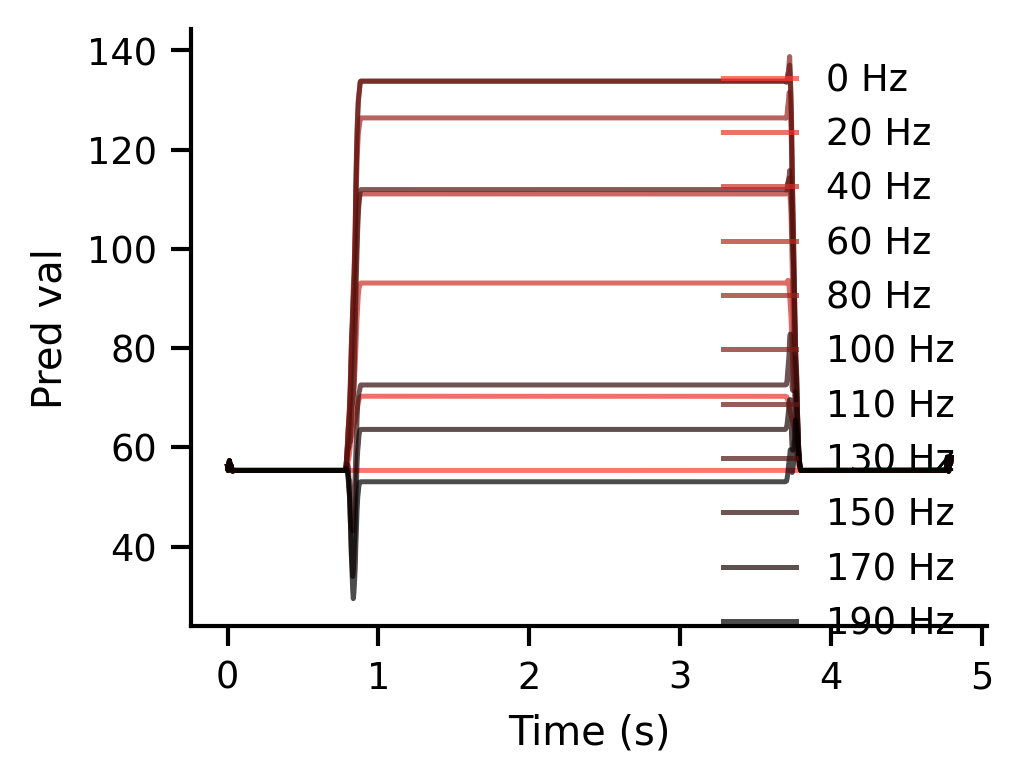

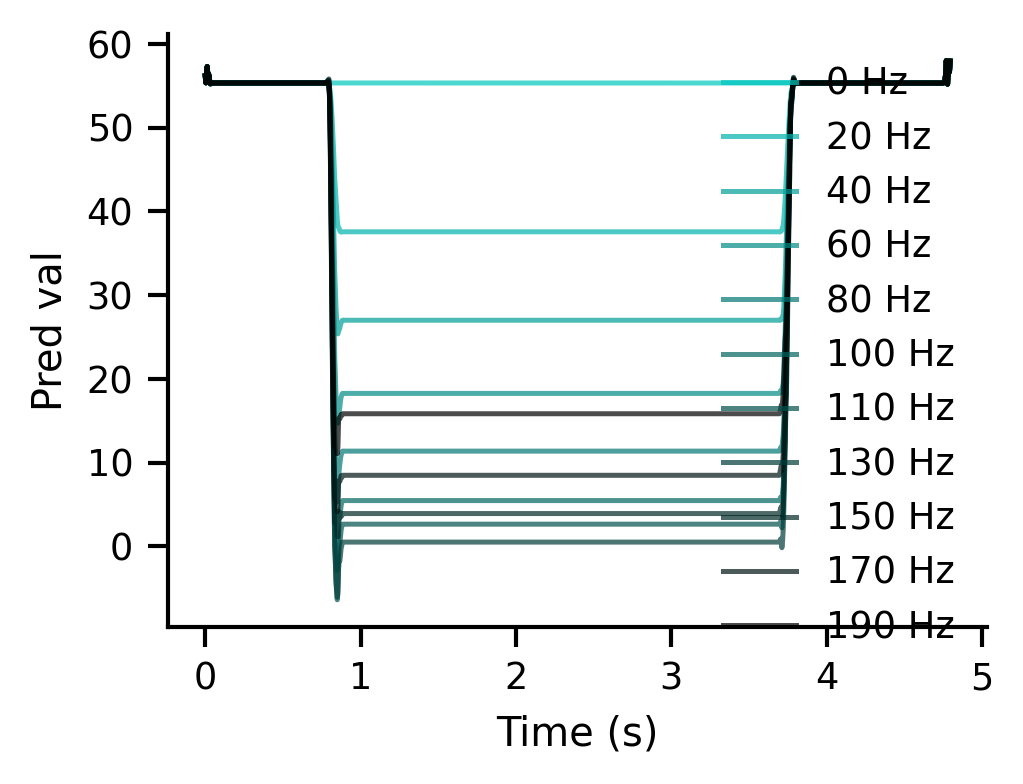

In [18]:
trial_to_plot = 4
plot_vib_output_per_freq(bic_trials_noNan, ELBOW_ANGLE_INDEX, path_save, trial_to_plot, "#"+original_hex_biceps,"biceps")
plot_vib_output_per_freq(tri_trials_noNan, ELBOW_ANGLE_INDEX, path_save, trial_to_plot, "#"+original_hex_tri,"triceps")

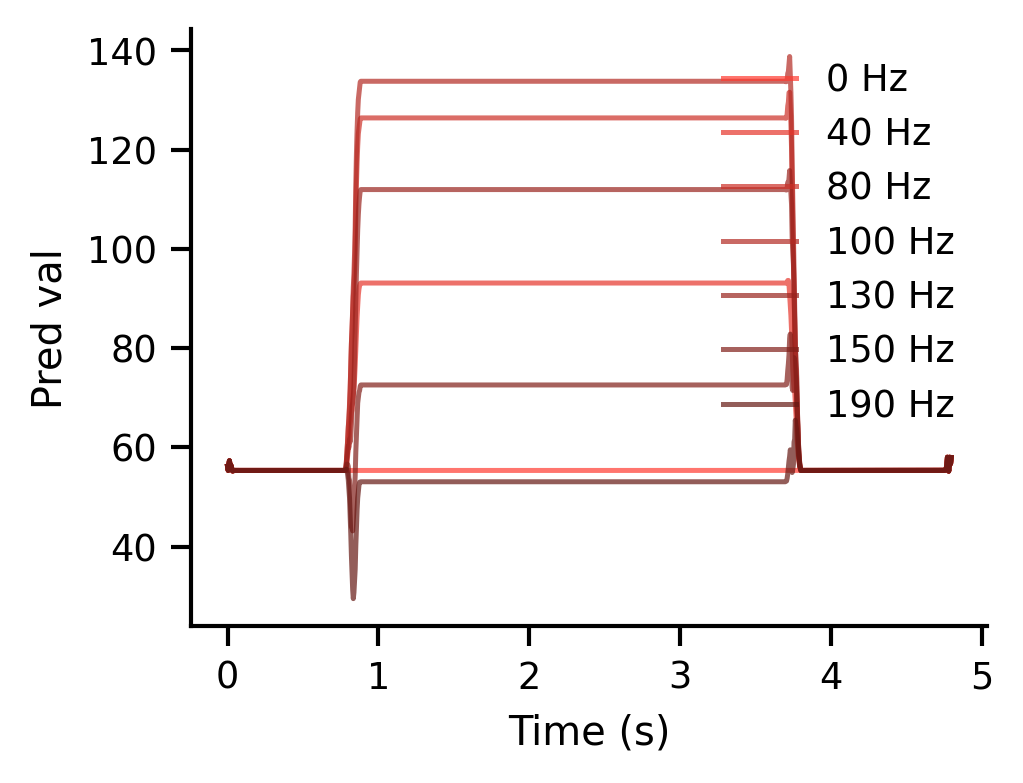

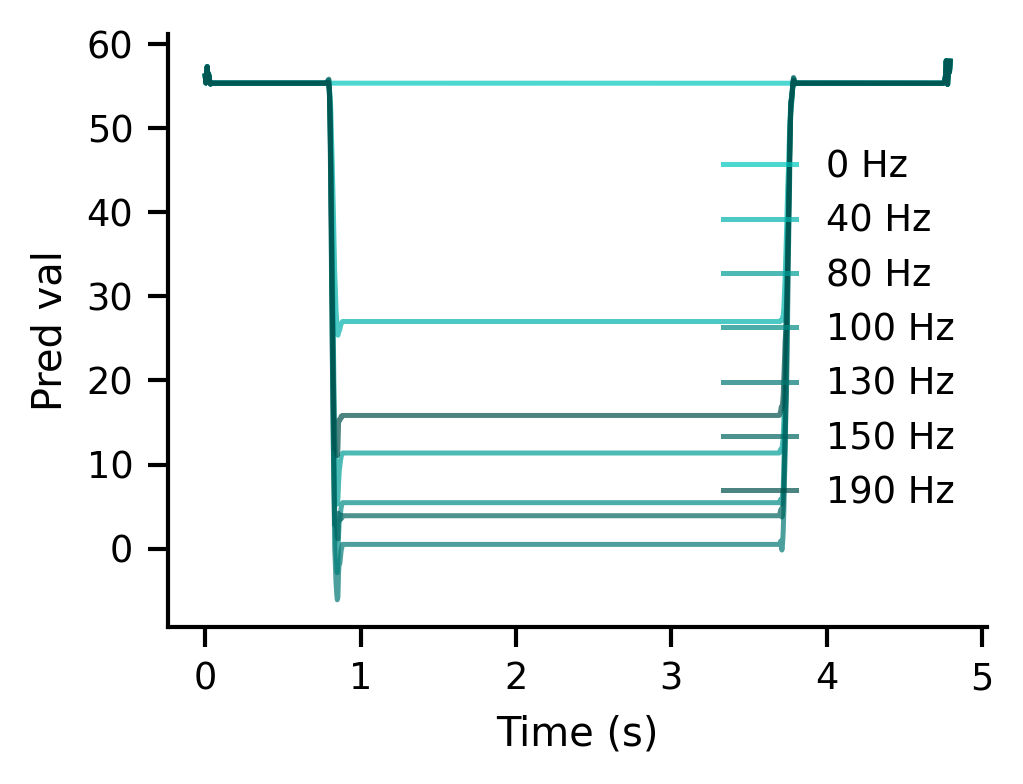

In [19]:
trial_to_plot = 4
vib_freq_plot = [0, 40, 80, 100, 130, 150, 190]
bic_trials_noNan_f = bic_trials_noNan[bic_trials_noNan["vib_freq"].isin(vib_freq_plot)]
tri_trials_noNan_f = tri_trials_noNan[tri_trials_noNan["vib_freq"].isin(vib_freq_plot)]
plot_vib_output_per_freq(bic_trials_noNan_f, ELBOW_ANGLE_INDEX, path_save, trial_to_plot, "#"+original_hex_biceps,"biceps_subFreq")
plot_vib_output_per_freq(tri_trials_noNan_f, ELBOW_ANGLE_INDEX, path_save, trial_to_plot, "#"+original_hex_tri,"triceps_subFreq")

## Fig 3b - by elbow angle

In [22]:
def plot_angleOffset_vs_vibration_elbowRange(df, save_path, suffix="", base_color="black", col_name=None, 
                                            margin_percent=0.1, y_min=None, y_max=None, num_ranges=5):
    """
    Plot 'offset_n_v_vib' and 'vib_angle_diff' vs. vibration frequency,
    colored by elbow angle ranges with dynamically adjusted axis ranges and dynamic elbow ranges.
    
    Args:
        df (pd.DataFrame): DataFrame containing trial results.
        save_path (str): Directory to save the generated plot.
        suffix (str): Suffix to add to the filename.
        base_color (str): Color for the mean line.
        col_name (str, optional): Column name to plot. If None, will try to find appropriate column.
        margin_percent (float): Percentage margin to add to data range (default: 10%).
        y_min (float, optional): Force minimum y-axis value. If None, calculated from data.
        y_max (float, optional): Force maximum y-axis value. If None, calculated from data.
        num_ranges (int): Number of elbow angle ranges to create (default: 5).
    """
    
    # Dynamically determine elbow angle ranges based on data
    # min_angle = df["elbow_angle"].min()
    # max_angle = df["elbow_angle"].max()
    
    # # Round to nearest 5 or 10 for cleaner bin edges
    # min_angle = np.floor(min_angle / 5) * 5
    # max_angle = np.ceil(max_angle / 5) * 5
    
    # # Create evenly spaced bins between min and max
    # elbow_angle_ranges = np.linspace(min_angle, max_angle, num_ranges + 1)
    elbow_angle_ranges =  [30, 60, 90, 120, 150]
    
    # Create range labels
    range_labels = [f"{int(elbow_angle_ranges[i])}-{int(elbow_angle_ranges[i+1])}°" 
                   for i in range(len(elbow_angle_ranges)-1)]
    
    df.loc[:, "elbow_angle_range"] = pd.cut(
        df["elbow_angle"], bins=elbow_angle_ranges, labels=range_labels
    )
    
    # Determine column to plot
    if col_name is None:
        if "vib_angle_diff" in df.columns:
            col_name = "vib_angle_diff"
        elif "vib_angle_diff_elbow" in df.columns:
            col_name = "vib_angle_diff_elbow"
        else:
            print("vib_angle_diff or vib_angle_diff_elbow not found in df")
            return
    
    jitter_strength = 3
    
    # Map ranges to colors
    if "TRI" in suffix:
        range_colors = cm.GnBu(np.linspace(0, 1, len(range_labels)))
    else:
        range_colors = cm.OrRd(np.linspace(0, 1, len(range_labels)))
    range_color_map = dict(zip(range_labels, range_colors))
    
    # Jittering setup
    vib_freq_name = "vib_freq_str" if isinstance(df["vib_freq"].iloc[0], list) else "vib_freq"
    df.loc[:,"jittered_vib_freq"] = df[vib_freq_name] + np.random.uniform(
        -jitter_strength, jitter_strength, size=len(df)
    )
    
    # Create figure and subplots (assuming BASE_FIG_SIZE_1COL is defined elsewhere)
    # If BASE_FIG_SIZE_1COL isn't defined in your environment, use a default size
    try:
        fig_size = BASE_FIG_SIZE_1COL
    except NameError:
        fig_size = (6, 5)  # Default size if BASE_FIG_SIZE_1COL is not defined
        
    fig, ax = plt.subplots(1, 1, figsize=fig_size, sharey=True)
    
    # Plotting
    for label, color in range_color_map.items():
        subset = df[df["elbow_angle_range"] == label]
        if not subset.empty:
            ax.scatter(
                subset["jittered_vib_freq"],
                subset[col_name],
                color=color,
                edgecolor="black",
                alpha=0.9,
                label=label,
                s=MS if 'MS' in globals() else 50  # Use default if MS not defined
            )
    
    # Plot the mean line if there are multiple vibration frequencies
    if len(df["vib_freq"].unique()) > 1:
        means = df.groupby("vib_freq")[col_name].mean()
        ax.plot(
            means.index,
            means.values,
            color=base_color,
            # marker='o',
            label='Mean'
        )
    
    # Dynamically set axis limits based on data
    # X-axis limits
    x_data = df["jittered_vib_freq"]
    x_min, x_max = x_data.min(), x_data.max()
    x_range = x_max - x_min
    x_margin = x_range * margin_percent
    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    
    # Y-axis limits
    y_data = df[col_name]
    # Use provided limits if specified, otherwise calculate from data
    if y_min is None:
        y_min = y_data.min()
    if y_max is None:
        y_max = y_data.max()
    y_range = y_max - y_min
    y_margin = y_range * margin_percent
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    
    # Improve grid and appearance
    # ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set labels
    ax.set_xlabel("Vibration Frequency (Hz)")
    ax.set_ylabel(f"{col_name.replace('_', ' ').title()} (deg)")
    
    # Add legend with better placement
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0.)
    ax.legend()
    
    # Save the plot with higher DPI
    plt.tight_layout()
    plt.savefig(f"{save_path}/vib_angle_diff_vsfreq_ElbowAngleRange_{suffix}.svg", 
                bbox_inches='tight', dpi=300)
    plt.savefig(f"{save_path}/vib_angle_diff_vsfreq_ElbowAngleRange_{suffix}.png", 
                bbox_inches='tight', dpi=300)
    
    plt.show()
    
    return fig, ax  # Return the figure and axis objects for further customization if needed

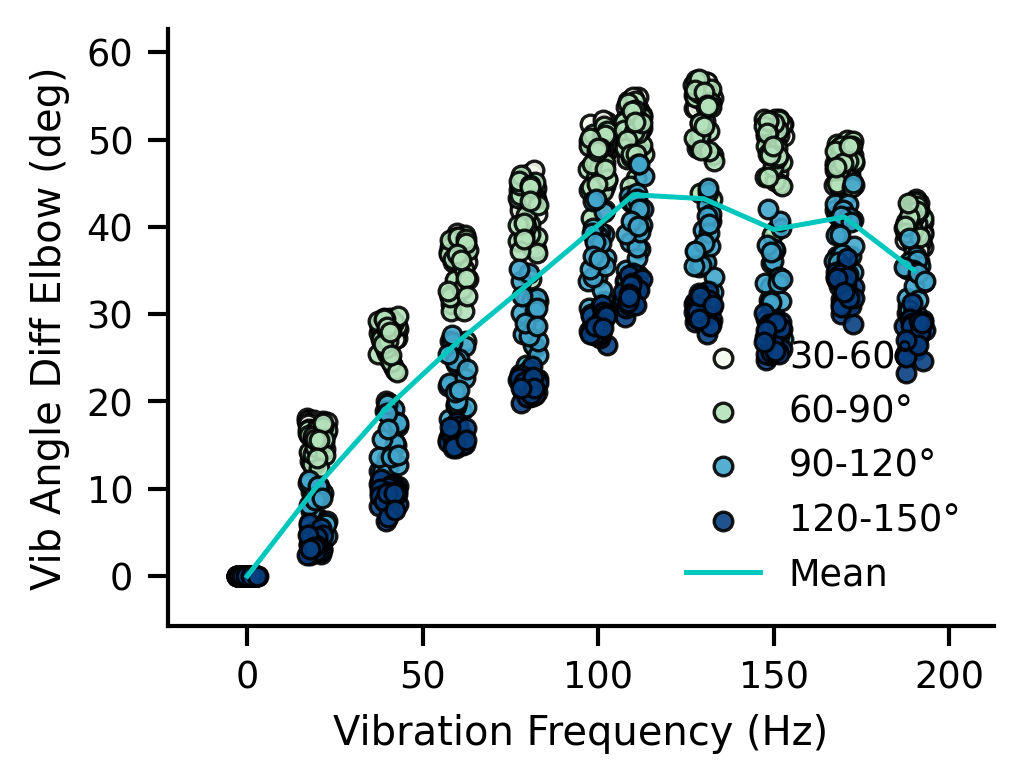

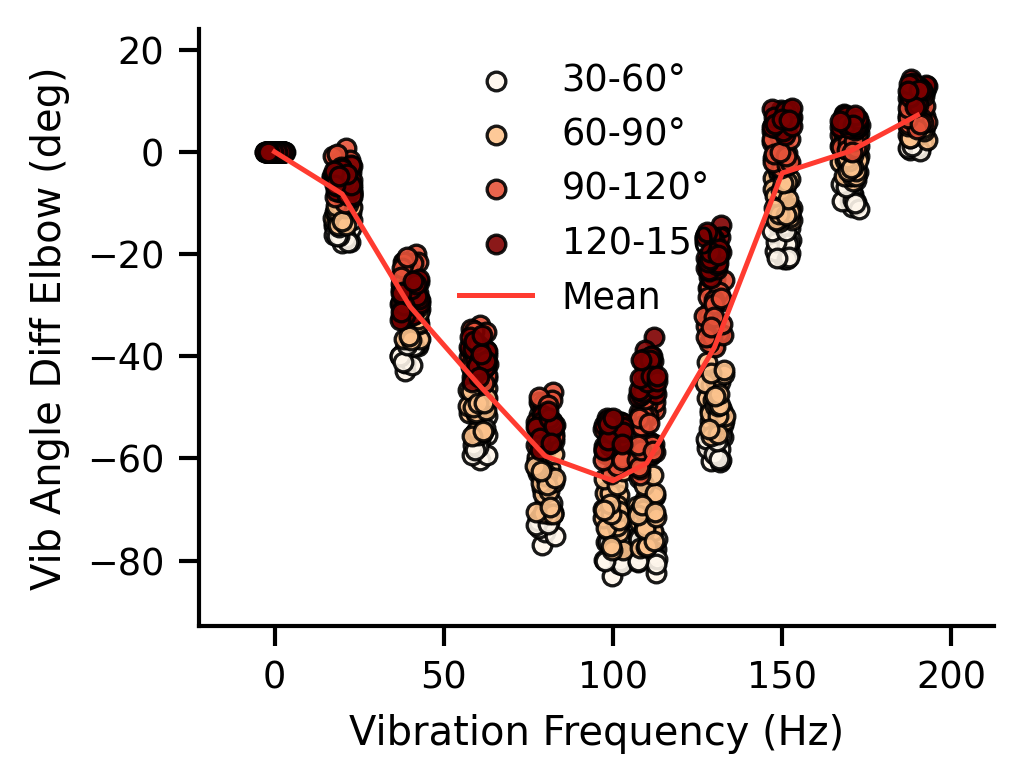

In [24]:
f, a = plot_angleOffset_vs_vibration_elbowRange(tri_trials, save_path=path_save, suffix ="TRIlat", base_color="#"+original_hex_tri)
f, a = plot_angleOffset_vs_vibration_elbowRange(bic_trials, save_path=path_save, suffix="BIClong", base_color="#"+original_hex_biceps)